In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 42.5 MB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import fiona
import matplotlib.pyplot as plot
%matplotlib inline

# Input Data

In [ ]:
# Reading input files from Uber movements
# Data is from January 2020 to March 2020
travel_times = pd.read_csv(
    '/content/gdrive/MyDrive/IYKRAA/ETA_Prediction/Travel_Times.csv'
    )
toronto_neigh_hourly = pd.read_csv(
    '/content/gdrive/MyDrive/IYKRAA/ETA_Prediction/toronto-neighbourhoods-2020-1-All-HourlyAggregate.csv'
    )

In [ ]:
travel_times.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
0,113,"1200 Hayes Street, Western Addition, San Franc...",1,"York University Busway, York University Height...","1/1/2020 - 3/30/2020, Every day, Daily Average",1935,1473,2541
1,113,"1200 Hayes Street, Western Addition, San Franc...",2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","1/1/2020 - 3/30/2020, Every day, Daily Average",911,660,1256
2,113,"1200 Hayes Street, Western Addition, San Franc...",3,"3400 Kingston Road, Scarborough Village, Scarb...","1/1/2020 - 3/30/2020, Every day, Daily Average",2115,1668,2681
3,113,"1200 Hayes Street, Western Addition, San Franc...",4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","1/1/2020 - 3/30/2020, Every day, Daily Average",837,551,1270
4,113,"1200 Hayes Street, Western Addition, San Franc...",5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","1/1/2020 - 3/30/2020, Every day, Daily Average",568,392,822


In [ ]:
toronto_neigh_hourly.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,33,135,7,2333.88,884.45,2188.31,1.42
1,132,12,7,1095.12,242.96,1068.57,1.25
2,130,32,7,2164.54,726.59,2051.44,1.39
3,131,22,7,1486.98,412.22,1433.79,1.31
4,66,2,18,2092.00,384.75,2056.50,1.20


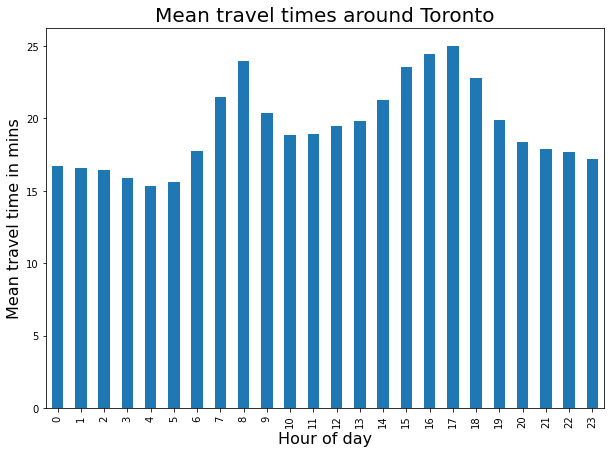

In [ ]:
# See busiest times to travel in Toronto
mean_travel_time_by_hour_of_day = toronto_neigh_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(10,7))
plt.set_title('Mean travel times around Toronto',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Mean travel time in mins', fontsize=16)

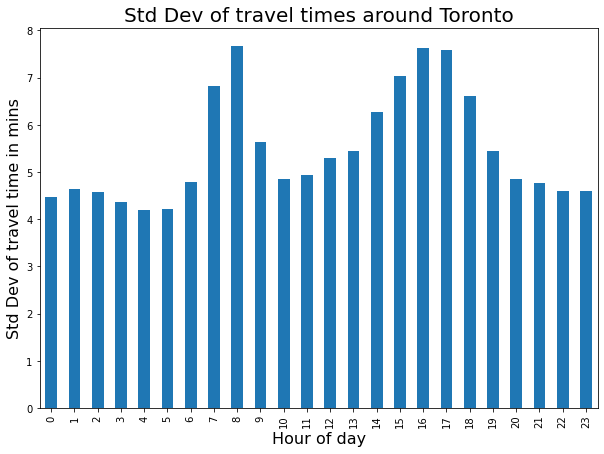

In [ ]:
std_dev_time_by_hour_of_day = toronto_neigh_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_time_by_hour_of_day.plot(kind="bar", figsize=(10,7))
plt.set_title('Std Dev of travel times around Toronto',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Std Dev of travel time in mins', fontsize=16)

# JSON Data

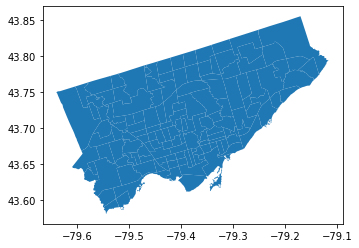

In [ ]:
# Plot Toronto map
toronto = gpd.read_file(
    '/content/gdrive/MyDrive/IYKRAA/ETA_Prediction/toronto_neighbourhoods.json'
    )
toronto.plot()

In [ ]:
toronto.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


In [ ]:
type(toronto)

geopandas.geodataframe.GeoDataFrame

# Pick Centroids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


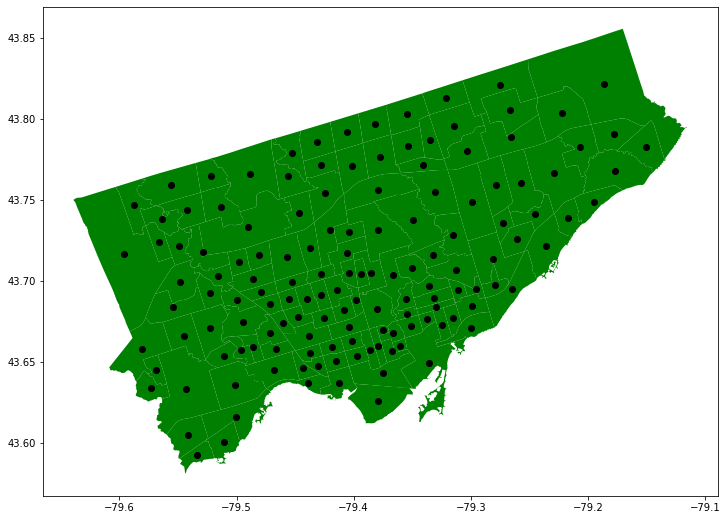

In [ ]:
# Plot centroids of each area in Toronto

toronto_c = toronto.drop(columns=['MOVEMENT_ID'])
# toronto_c = toronto.copy()
toronto_c.geometry = toronto_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(15,9))
toronto.plot(color='green',ax=ax)
toronto_c.plot(color='black',ax=ax)

In [ ]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()

,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


# Get Some Random Points

In [ ]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:2]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(toronto_c)
diversified_points.sample(5)

,DISPLAY_NAME,geometry
208,"1700 Eglinton Avenue East, North York, Toronto",POINT (-79.31487 43.72849)
29,"4200 Lawrence Avenue East, West Hill, Scarboro...",POINT (-79.17668 43.76749)
132,"0 Apex Road, Yorkdale, North York, Toronto",POINT (-79.45711 43.71467)
316,"0 Ridgevale Drive, Englemount - Lawrence, Nort...",POINT (-79.43741 43.72035)
63,"0 Pondsview Drive, Pleasant View, North York, ...",POINT (-79.33495 43.78698)


In [ ]:
diversified_points.shape

(423, 2)

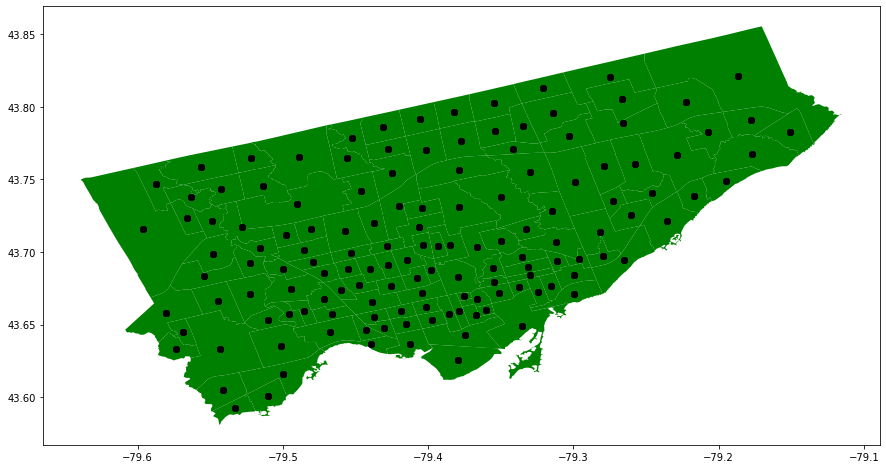

In [ ]:
fig, ax = plot.subplots(figsize=(15,12))
toronto.plot(color='green',ax=ax)
diversified_points.plot(color='black',ax=ax)

# Data Cleansing for Analysis

In [ ]:
time_df = pd.merge(toronto_neigh_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
279984,141,140,20,1518.76,284.21,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279974,141,140,21,1528.77,300.13,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279980,141,140,22,1481.58,303.79,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279972,141,140,23,1431.77,301.57,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
369895,141,141,23,297.76,229.63,"Water's Edge Promenade, Downtown, Old Toronto,...","Water's Edge Promenade, Downtown, Old Toronto,..."


In [ ]:
toronto_c.shape

(141, 2)

In [ ]:
diversified_points.shape

(423, 2)

In [ ]:
full_toronto = toronto_c.append(diversified_points, ignore_index=True)
full_toronto.shape

(564, 2)

In [ ]:
time_df2 = pd.merge(time_df, full_toronto, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_toronto, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Geometry,Destination Geometry
2882081,64,69,21,1431.33,234.89,"500 Spadina Road, Midtown Toronto, Old Toronto...","100 Torbrick Road, East Danforth, Old Toronto,...",POINT (-79.41432 43.69453),POINT (-79.32432 43.67261)
2824454,39,68,13,1059.37,227.30,"100 Glengrove Avenue West, Midtown Toronto, Ol...","100 Eddystone Avenue, Jane and Finch, North Yo...",POINT (-79.40604 43.71721),POINT (-79.51347 43.74564)
3412628,62,81,10,1285.88,275.37,"0 Nairn Avenue, Earlscourt, York, Toronto","100 Parkway Forest Drive, Henry Farm, North Yo...",POINT (-79.44747 43.67766),POINT (-79.34124 43.77114)


In [ ]:
time_df2.shape

(6334176, 9)

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

output_path = '/content/gdrive/MyDrive/IYKRAA/ETA_Prediction/Output/'

# Calculate Distance

In [ ]:
# Calculate distance from source point to destination using geopy.distance
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = output_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, filename)
except:
    pass

In [ ]:
final_df.head()

,Source lat,Source long,Dest lat,Dest long,hod,Geodesic Distance,mean_travel_time
0,43.765737,-79.488883,43.765737,-79.488883,23,0.0,264.18
1,43.765737,-79.488883,43.765737,-79.488883,23,0.0,264.18
2,43.765737,-79.488883,43.765737,-79.488883,23,0.0,264.18
3,43.765737,-79.488883,43.765737,-79.488883,23,0.0,264.18
4,43.765737,-79.488883,43.765737,-79.488883,23,0.0,264.18


# Modeling

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### We created different random forest variants, with varied max_depth

In [ ]:
# First variant has max_depth of 10

filename = 'randomforestreg_1.bin'
path = output_path + filename

# Check if model exists in folder
if file_exists(path):
    with open(path, 'rb') as file:
        regr = pickle.load(file)
else:
    # Fit model to training data
    regr = RandomForestRegressor(max_depth=10, min_samples_leaf=5, random_state=5)
    regr.fit(X_train, np.ravel(y_train))

try:    
  save_object(regr, path)
except:
    pass

In [ ]:
# Predict model using testing data
reg_pred = regr.predict(X_test)

# Evaluate model using R2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error
from sklearn import metrics
r2 = metrics.r2_score(y_test, reg_pred)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, reg_pred)
print('MSE: {}\n'.format(mse))
print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, reg_pred)
print('MAE: {}\n'.format(mae))

R2: 0.7941197771236725

MSE: 58833.49673831617

RMSE: 242.5561723360512

MAE: 179.47137000980516



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


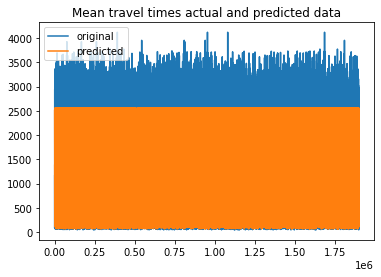

In [ ]:
# Plot original time and predicted time comparison
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, reg_pred, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

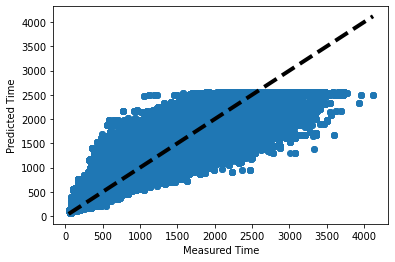

In [ ]:

fig, ax = plot.subplots()
ax.scatter(y_test, reg_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

In [ ]:
# The model doesn't fit the data well, we can see that predicted time has some maximal value at around 2500 s
# Try another random forest

In [ ]:
# Second variant has max_depth of 20
filename = 'randomforestreg_2.bin'
path = output_path + filename

# Check if model exists in folder
if file_exists(path):
    with open(path, 'rb') as file:
        regr = pickle.load(file)
else:
    # Fit model to training data
    regr = RandomForestRegressor(max_depth=20, min_samples_leaf=5, random_state=5)
    regr.fit(X_train, np.ravel(y_train))

try:    
  save_object(regr, path)
except:
    pass

In [ ]:
# Predict model using testing data
reg_pred = regr.predict(X_test)

# Evaluate model using R2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error
from sklearn import metrics
r2 = metrics.r2_score(y_test, reg_pred)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, reg_pred)
print('MSE: {}\n'.format(mse))
print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, reg_pred)
print('MAE: {}\n'.format(mae))

R2: 0.9846128171730204

MSE: 4397.128378896229

RMSE: 66.31084661574025

MAE: 38.49412887857128



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


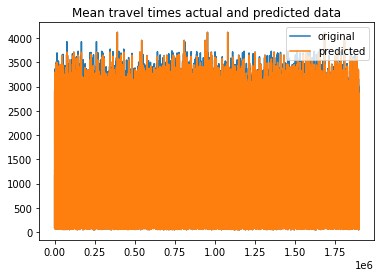

In [ ]:
# Plot original time and predicted time comparison
x_ax = range(len(y_test))

plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, reg_pred, label="predicted")
plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

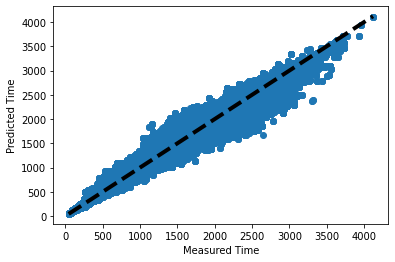

In [ ]:
fig, ax = plot.subplots()
ax.scatter(y_test, reg_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

In [ ]:
# This model fit the data better, and has high R2 score

# Testing with Random Points

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df):
    return my_model.predict(df[features])

def compare(actual, predicted):
    return pd.DataFrame(data = {'actual': actual, 'prediction': predicted})

In [ ]:
points = []

# Set boundaries only for Toronto
min_x, min_y, max_x, max_y = 43.60, -79.55, 43.77, -79.18 
(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
i= 0

# Generate random points to use as source and destination
while i < 10:
    src_point = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
    dest_point = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
    point = (src_point, dest_point)
    i += 1
    points.append(point)
points

[((43.714603171063736, -79.52957726645435),
  (43.75284061751854, -79.20205560392176)),
 ((43.73779631036035, -79.28803249526601),
  (43.71653831490479, -79.46449450333434)),
 ((43.76414838401571, -79.30017689899641),
  (43.66319176054731, -79.52085454857371)),
 ((43.6359585835774, -79.51522141713372),
  (43.648877358681446, -79.39501735660309)),
 ((43.619981153207625, -79.4381971437355),
  (43.69028244731034, -79.53038874699033)),
 ((43.72037502406163, -79.38979605547301),
  (43.740559398758016, -79.28385995032878)),
 ((43.724033154314455, -79.42027853829595),
  (43.69314205018856, -79.42427311079145)),
 ((43.668376039798446, -79.2057731838809),
  (43.64791807907335, -79.44941190714334)),
 ((43.685764896041206, -79.45248455120624),
  (43.633508714806894, -79.21377248120598)),
 ((43.61266040841089, -79.22852192091285),
  (43.71435910056848, -79.31534850240698))]

In [ ]:
# Some generated points ended up in the middle of Lake Ontario
# We tweaked all those coordinates a bit to Port Lands

points_no_lake = [((43.714603171063736, -79.52957726645435),
  (43.75284061751854, -79.20205560392176)),
 ((43.73779631036035, -79.28803249526601),
  (43.71653831490479, -79.46449450333434)),
 ((43.76414838401571, -79.30017689899641),
  (43.66319176054731, -79.52085454857371)),
 ((43.6359585835774, -79.51522141713372),
  (43.648877358681446, -79.39501735660309)),
 ((43.6481034683671, -79.34178191689494),
  (43.69028244731034, -79.53038874699033)),
 ((43.72037502406163, -79.38979605547301),
  (43.740559398758016, -79.28385995032878)),
 ((43.724033154314455, -79.42027853829595),
  (43.69314205018856, -79.42427311079145)),
 ((43.6481034683671, -79.34178191689494),
  (43.64791807907335, -79.44941190714334)),
 ((43.685764896041206, -79.45248455120624),
  (43.6481034683671, -79.34178191689494)),
 ((43.6481034683671, -79.34178191689494),
  (43.71435910056848, -79.31534850240698))]

In [ ]:
# Manually check travel times from each points using Google Maps

# Hours of day in WIB (time of extraction)
hours_of_day_wib = [13, 13, 18, 13, 18, 13, 13, 18, 18, 18]

# Hours of day in Toronto Time
hours_of_day = [i-11 for i in hours_of_day_wib]

travel_times_gmaps_in_mins = [24, 20, 29, 17, 26, 17, 7, 17, 28, 16]
travel_times_gmaps = [t*60 for t in travel_times_gmaps_in_mins]

In [ ]:
travel_times_model = []
points1 = [p[0] for p in points_no_lake]
points2 = [p[1] for p in points_no_lake]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod))
    p = p.tolist()[0]
    travel_times_model.append(p)
[t/60 for t in travel_times_model]

[20.43996378580729,
 19.660215250651042,
 29.43629353841146,
 16.628284708658853,
 30.229168701171876,
 14.578668212890625,
 8.300903828938802,
 21.966459147135417,
 25.780240885416667,
 20.71866658528646]

In [ ]:
# Compare the actual travel times with predicted travel times
df_compare = compare(travel_times_gmaps, travel_times_model)
df_compare["diff"] = (df_compare["prediction"] - df_compare["actual"])/60

df_compare

,actual,prediction,diff
0,1440,1226.397827,-3.560036
1,1200,1179.612915,-0.339785
2,1740,1766.177612,0.436294
3,1020,997.697083,-0.371715
4,1560,1813.750122,4.229169
5,1020,874.720093,-2.421332
6,420,498.054230,1.300904
7,1020,1317.987549,4.966459
8,1680,1546.814453,-2.219759
9,960,1243.119995,4.718667


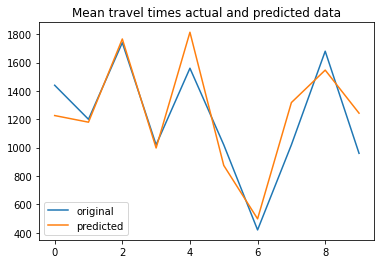

In [ ]:
# Plot both travel times

x_ax = range(len(travel_times_model))

plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model, label="predicted")
plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

# Live Testing

In [ ]:
# Get random points and set as source and destination
# Let's travel from York University to Ontario Science Centre

src_point_tes = [43.77340238964325, -79.5018178899002]
dest_point_tes = [43.717303195452715, -79.33914640029785]
lat1, long1 = src_point_tes[0], src_point_tes[1]
lat2, long2 = dest_point_tes[0], dest_point_tes[1]
hod = 10

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([1485.6494], dtype=float32)